In [1]:
import sys,os,os.path
sys.path.append(os.path.expanduser('~/Codes/SolutionDistillation'))
import numpy as np
import tensorflow as tf
import os
from distill.common.hparams import TransformerHparam, LSTMHparam
from distill.data_util.prep_algorithmic import AlgorithmicIdentityDecimal40, AlgorithmicAdditionDecimal40, \
  AlgorithmicMultiplicationDecimal40, AlgorithmicSortProblem, AlgorithmicReverseProblem, AlgorithmicIdentityBinary40
from distill.data_util.prep_arithmatic import Arithmatic, ArithmaticSimpleSameLength10
from distill.data_util.prep_imdb import IMDB
from distill.data_util.prep_ptb import PTB
from distill.data_util.prep_sst import SST
from distill.data_util.prep_wsj_parsing import ParseWSJ
from distill.models.lstm_seq2seq import LSTMSeq2Seq, BidiLSTMSeq2Seq
from distill.models.transformer import Transformer, UniversalTransformer, EncodingTransformer, \
  EncodingUniversalTransformer
from distill.pipelines.seq2seq import Seq2SeqTrainer
from distill.models.transformer import Transformer, UniversalTransformer, EncodingTransformer, \
  EncodingUniversalTransformer
from distill.pipelines.distill_pipelines import Seq2SeqDistiller
from distill.pipelines.seq2seq import Seq2SeqTrainer

# Enable TF Eager execution
tfe = tf.contrib.eager
tfe.enable_eager_execution()

# Other setup
Modes = tf.estimator.ModeKeys

In [2]:

task = ArithmaticSimpleSameLength10('data/arithmatic_simple_samelength10')

transformer_params = TransformerHparam(input_dim=task.vocab_length,
                                         hidden_dim=300,
                                         output_dim=len(task.target_vocab),
                                         encoder_depth=2,
                                         decoder_depth=1,
                                         number_of_heads=2,
                                         ff_filter_size=512,
                                         initializer_gain=0.1,
                                         batch_size=32,
                                         input_dropout_keep_prob=1.0,
                                         hidden_dropout_keep_prob=1.0,
                                         vocab_size=task.vocab_length,
                                         label_smoothing=0.1,
                                         encoder_self_attention_dir="top_down",
                                         decoder_self_attention_dir="top_down",
                                         decoder_cross_attention_dir="top_down",
                                         train_embeddings=False,
                                         learning_rate=0.001
                                         )
trainer = Seq2SeqTrainer(transformer_params, None, task)



['<pad>', '<eos>', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '(', ')', '+', '-']
0 <pad>
1 <eos>
2 0
3 1
4 2
5 3
6 4
7 5
8 6
9 7
10 8
11 9
12 (
13 )
14 +
15 -


In [3]:
train_dataset = tf.data.TFRecordDataset("../"+task.get_tfrecord_path(mode="train"))
train_dataset = train_dataset.map(task.parse_examples)
train_dataset = train_dataset.padded_batch(100, padded_shapes=task.get_padded_shapes())
train_dataset = train_dataset.map((lambda x1,x2,x3,x4: ((x1,x2,x3,x4),(x1,x2,x3,x4))))
train_dataset = train_dataset.shuffle(buffer_size=100)
train_dataset = train_dataset.repeat()

train_examples = tfe.Iterator(train_dataset).next()



dev_dataset = tf.data.TFRecordDataset("../"+task.get_tfrecord_path(mode="dev"))
dev_dataset = dev_dataset.map(task.parse_examples)
dev_dataset = dev_dataset.padded_batch(100, padded_shapes=task.get_padded_shapes())
dev_dataset = dev_dataset.shuffle(buffer_size=100)
dev_dataset = dev_dataset.repeat()

dev_examples = tfe.Iterator(dev_dataset).next()




test_dataset = tf.data.TFRecordDataset("../"+task.get_tfrecord_path(mode="test"))
test_dataset = test_dataset.map(task.parse_examples)
test_dataset = test_dataset.padded_batch(100, padded_shapes=task.get_padded_shapes())
test_dataset = test_dataset.shuffle(buffer_size=100)
test_dataset = test_dataset.repeat()

test_examples = tfe.Iterator(test_dataset).next()


Instructions for updating:
Colocations handled automatically by placer.


In [4]:
x,y= train_examples

In [5]:
x[0]

<tf.Tensor: id=61, shape=(100, 78), dtype=int64, numpy=
array([[12, 12,  5, ...,  0,  0,  0],
       [12,  9, 14, ...,  0,  0,  0],
       [12, 12, 12, ...,  0,  0,  0],
       ...,
       [12,  6, 15, ...,  0,  0,  0],
       [12, 12,  6, ...,  0,  0,  0],
       [ 8,  1,  0, ...,  0,  0,  0]])>

In [6]:
y[1]

<tf.Tensor: id=66, shape=(100, 1), dtype=int64, numpy=
array([[8],
       [8],
       [3],
       [8],
       [8],
       [0],
       [7],
       [6],
       [9],
       [2],
       [1],
       [7],
       [3],
       [4],
       [9],
       [7],
       [5],
       [5],
       [3],
       [5],
       [4],
       [3],
       [9],
       [2],
       [8],
       [6],
       [5],
       [7],
       [6],
       [6],
       [5],
       [1],
       [0],
       [4],
       [8],
       [0],
       [3],
       [3],
       [4],
       [2],
       [8],
       [2],
       [4],
       [8],
       [1],
       [0],
       [8],
       [6],
       [9],
       [0],
       [6],
       [5],
       [8],
       [5],
       [7],
       [4],
       [5],
       [6],
       [6],
       [3],
       [1],
       [1],
       [3],
       [5],
       [0],
       [7],
       [9],
       [2],
       [7],
       [4],
       [0],
       [1],
       [9],
       [6],
       [3],
       [8],
       [9],
       [0],
       [1

In [7]:
def get_stats_from_examples(batched_examples):
    lengthes = []
    targets = []
    for example_inputs, example_targets in zip(batched_examples[0], batched_examples[1]):
        np_example_inputs = example_inputs.numpy()
        np_example_targets = example_targets.numpy()[0]
        if 0 in list(np_example_inputs):
            length = list(np_example_inputs).index(0)
        else:
            length = len(np_example_inputs)
        lengthes.append(length)
        targets.append(np_example_targets)
    return lengthes, targets

In [8]:
!pip install matplotlib

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline  


lengthes, targets = get_stats_from_examples(train_examples)

n, bins, patches = plt.hist(lengthes, 100, density=True, facecolor='g', alpha=0.75)
plt.show()

n, bins, patches = plt.hist(targets, 100, density=True, facecolor='g', alpha=0.75)
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline  


lengthes, targets = get_stats_from_examples(dev_examples)

n, bins, patches = plt.hist(lengthes, 20, density=True, facecolor='g', alpha=0.75)
plt.show()

n, bins, patches = plt.hist(targets, 20, density=True, facecolor='g', alpha=0.75)
plt.show()

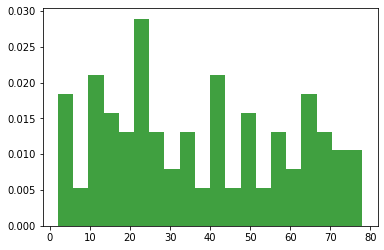

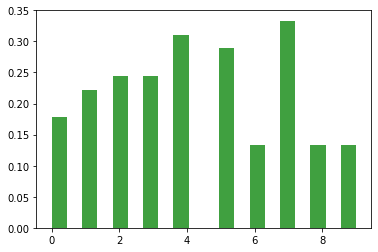

In [10]:


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline  


lengthes, targets = get_stats_from_examples(test_examples)

n, bins, patches = plt.hist(lengthes, 20, density=True, facecolor='g', alpha=0.75)
plt.show()

n, bins, patches = plt.hist(targets, 20, density=True, facecolor='g', alpha=0.75)
plt.show()

In [9]:
print(task.decode(task.encode(str("1 + 1").split())))


['1', '+', '1']


In [7]:
i = np.random.randint(len(train_examples))
print(i)
example_inputs, example_targets = list(zip(train_examples[0], train_examples[1]))[i]
print(' '.join(task.decode(example_inputs)).replace('<pad>',''))
print(eval(' '.join(task.decode(example_inputs)).replace('<pad>','').replace('<eos>', '')))

print(task.decode((example_targets)))


print(' '.join(task.decode(example_inputs)).replace('<pad>',''))
print(eval(' '.join(task.decode(example_inputs)).replace('<pad>','').replace('<eos>', '')))

print(example_targets)


3
( ( 5 + ( 1 + 1 ) ) + 1 ) <eos>                                                                
8
['6']
( ( 5 + ( 1 + 1 ) ) + 1 ) <eos>                                                                
8
tf.Tensor([8], shape=(1,), dtype=int64)


In [11]:
model_1 = EncodingTransformer(transformer_params, task, "model_1")
model_2 = EncodingTransformer(transformer_params, task, "model_2")

trainer = Seq2SeqTrainer(transformer_params, model_1, task)
distiller = Seq2SeqDistiller(transformer_params, model_1, model_2, trainer)
    
trainer.compute_loss(tf.one_hot(example_targets,10),example_targets)

NameError: name 'example_targets' is not defined

In [29]:
example_targets

<tf.Tensor: id=30195, shape=(1,), dtype=int64, numpy=array([0])>

In [30]:
tf.one_hot(example_targets,16)

<tf.Tensor: id=41939, shape=(1, 16), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [31]:
from distill.common.metrics import padded_cross_entropy_loss, get_eval_metrics, cross_entropy_loss

In [32]:
entropy, weights = cross_entropy_loss(tf.one_hot(example_targets,10),example_targets,smoothing=0.0,vocab_size=10)

In [33]:
weights

<tf.Tensor: id=42005, shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>

In [34]:
entropy

<tf.Tensor: id=42001, shape=(1,), dtype=float32, numpy=array([1.46115], dtype=float32)>

In [35]:
soft_targets = tf.one_hot(
            tf.cast(example_targets, tf.int32),
            depth=10,
            on_value=1.0,
            off_value=0.0)
              
      
      
xentropy = tf.nn.softmax_cross_entropy_with_logits_v2(
  logits=soft_targets*100, labels=soft_targets)

In [36]:
xentropy

<tf.Tensor: id=42048, shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>

In [37]:
soft_targets

<tf.Tensor: id=42014, shape=(1, 10), dtype=float32, numpy=array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [38]:
tf.one_hot(example_targets,10)

<tf.Tensor: id=42054, shape=(1, 10), dtype=float32, numpy=array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [39]:
model.create_vars()
outputs = model.apply(train_examples)

INFO:tensorflow:encoder inputs:
INFO:tensorflow:tf.Tensor(
[[[-1.8922591   1.2876995   0.21561565 ...  0.82794106 -1.100456
    2.2643883 ]
  [-0.16684943  1.5281111  -0.8646378  ...  0.93271714 -0.2978449
    0.90899265]
  [ 0.9092974   0.9525413   0.9807326  ...  1.          1.
    1.        ]
  ...
  [-0.38778165  0.9835683  -0.29994795 ...  0.999964    0.9999682
    0.99997187]
  [ 0.56610763  0.72585195 -0.92775476 ...  0.99996305  0.99996734
    0.9999711 ]
  [ 0.9995202  -0.12743618 -0.8769779  ...  0.99996203  0.99996644
    0.9999704 ]]

 [[-0.40166563  0.67720133 -0.6940341  ...  1.0584941  -0.2808777
   -0.3138336 ]
  [ 0.4398054   1.4847932   0.07906193 ...  1.0584941  -0.2808777
   -0.3138336 ]
  [ 0.5076318   1.6297426   0.28669852 ...  1.0584941  -0.2808777
   -0.3138336 ]
  ...
  [-0.38778165  0.9835683  -0.29994795 ...  0.999964    0.9999682
    0.99997187]
  [ 0.56610763  0.72585195 -0.92775476 ...  0.99996305  0.99996734
    0.9999711 ]
  [ 0.9995202  -0.12743618 -0.

In [23]:
outputs.shape

TensorShape([Dimension(1000), Dimension(1), Dimension(10)])

In [24]:
tf.nn.softmax(outputs)

<tf.Tensor: id=40896, shape=(1000, 1, 10), dtype=float32, numpy=
array([[[0.00715524, 0.09209497, 0.0917704 , ..., 0.03556783,
         0.04943119, 0.15343009]],

       [[0.02895103, 0.04006007, 0.26865193, ..., 0.00580688,
         0.07627358, 0.02107685]],

       [[0.04077142, 0.02672941, 0.23326753, ..., 0.00361042,
         0.04985133, 0.04474999]],

       ...,

       [[0.01969549, 0.02658502, 0.2711329 , ..., 0.00517109,
         0.05861397, 0.04302977]],

       [[0.02205601, 0.05488703, 0.26217592, ..., 0.00449226,
         0.06337234, 0.0239463 ]],

       [[0.04000373, 0.05206897, 0.24202158, ..., 0.01508354,
         0.07866572, 0.02239132]]], dtype=float32)>

In [40]:
outputs['trainable_vars']

[]

In [41]:
model.scope

'Transformer'

In [13]:
g = tf.Graph()
with g.as_default():
    model_1.create_vars(False)
    model_2.create_vars(False)
    print(tf.trainable_variables("model_1"))
    print(tf.trainable_variables("model_2"))

[<tf.Variable 'model_1/TransformerEncoder/layer_norm_scale:0' shape=(300,) dtype=float32_ref>, <tf.Variable 'model_1/TransformerEncoder/layer_norm_bias:0' shape=(300,) dtype=float32_ref>]
[<tf.Variable 'model_2/TransformerEncoder/layer_norm_scale:0' shape=(300,) dtype=float32_ref>, <tf.Variable 'model_2/TransformerEncoder/layer_norm_bias:0' shape=(300,) dtype=float32_ref>]


In [17]:
model = EncodingTransformer(transformer_params, task)
model.create_vars(False)
print(tf.trainable_variables())

[]
